# **Regresión Logística Ridge (L2) y Lasso (L1)**

# 1.Imports y configuración

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_score, recall_score, accuracy_score, f1_score, RocCurveDisplay
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, ADASYN


In [2]:
import warnings
warnings.filterwarnings("ignore")


In [3]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": False,  # Evita depender de LaTeX
    "font.family": "sans-serif",  # ompatible en todos los entornos
    "font.sans-serif": ["DejaVu Sans"]  # Fuente segura y preinstalada
})


# 2.Cargar datos y separación

In [4]:
# df = pd.read_csv("ruta_al_dataset.csv")
df = pd.read_csv(r"C:\Users\DELL\Desktop\Aprendizaje_de_Maquina\credit_risk_the_end.csv")
X = df.drop(columns=["incumplimiento_credito"])
y = df["incumplimiento_credito"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


# 3.Preprocesamiento

In [5]:
num_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
])


# 4.Definir Pipelines por Penalización y Técnica de Balanceo

In [6]:
pipelines = {
    "SMOTE_L1": ImbPipeline([
        ("pre", preprocessor),
        ("over", SMOTE(random_state=42)),
        ("clf", LogisticRegression(penalty='l1', solver='saga', max_iter=1000))
    ]),
    "ADASYN_L1": ImbPipeline([
        ("pre", preprocessor),
        ("over", ADASYN(random_state=42)),
        ("clf", LogisticRegression(penalty='l1', solver='saga', max_iter=1000))
    ]),
    "Balanced_L1": Pipeline([
        ("pre", preprocessor),
        ("clf", LogisticRegression(penalty='l1', solver='saga', class_weight="balanced", max_iter=1000))
    ]),
    "SMOTE_L2": ImbPipeline([
        ("pre", preprocessor),
        ("over", SMOTE(random_state=42)),
        ("clf", LogisticRegression(penalty='l2', solver='saga', max_iter=1000))
    ]),
    "ADASYN_L2": ImbPipeline([
        ("pre", preprocessor),
        ("over", ADASYN(random_state=42)),
        ("clf", LogisticRegression(penalty='l2', solver='saga', max_iter=1000))
    ]),
    "Balanced_L2": Pipeline([
        ("pre", preprocessor),
        ("clf", LogisticRegression(penalty='l2', solver='saga', class_weight="balanced", max_iter=1000))
    ])
}


# 5.GridSearchCV y Evaluación por Técnica

In [7]:
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10, 100]
}

results = []

for name, pipe in pipelines.items():
    print(f"🔍 Entrenando {name}...")
    t0 = time.time()
    grid = GridSearchCV(pipe, param_grid, scoring="recall", cv=5, n_jobs=8)
    grid.fit(X_train, y_train)
    fit_time = (time.time() - t0) / 60

    best_model = grid.best_estimator_
    y_prob = best_model.predict_proba(X_test)[:, 1]
    y_pred = best_model.predict(X_test)

    results.append({
        "Método": name,
        "Mejor_C": grid.best_params_["clf__C"],
        "Precision": precision_score(y_test, y_pred),
        "Recall1": recall_score(y_test, y_pred),
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob),
        "Tiempo(m)": fit_time,
        "y_pred": y_pred,
        "y_prob": y_prob,
        "best_model": best_model
    })




🔍 Entrenando SMOTE_L1...
🔍 Entrenando ADASYN_L1...
🔍 Entrenando Balanced_L1...
🔍 Entrenando SMOTE_L2...
🔍 Entrenando ADASYN_L2...
🔍 Entrenando Balanced_L2...


# 6. Métricas de Métricas por Algoritmo

In [8]:
import seaborn as sns
from matplotlib import colors

# Crear un colormap pastel (inspirado en la paleta Pastel1)
pastel_cmap = sns.color_palette("Pastel1", as_cmap=True)

# Tabla con formato pastel
df_results = pd.DataFrame(results).drop(columns=["y_pred", "y_prob", "best_model"])
df_results = df_results.sort_values(by="Recall1", ascending=False)

# Aplicar estilo
styled = df_results.style.background_gradient(
    cmap=pastel_cmap,
    subset=["Precision", "Recall1", "Accuracy", "F1", "AUC", "Tiempo(m)"]
).format("{:.4f}", subset=["Precision", "Recall1", "Accuracy", "F1", "AUC", "Tiempo(m)"])

display(styled)


,Método,Mejor_C,Precision,Recall1,Accuracy,F1,AUC,Tiempo(m)
2,Balanced_L1,0.010000,0.1687,0.6648,0.6914,0.2691,0.7433,1.7508
5,Balanced_L2,1.000000,0.1683,0.6624,0.6915,0.2684,0.7445,2.0669
4,ADASYN_L2,0.100000,0.1678,0.6604,0.6911,0.2676,0.7406,4.6755
1,ADASYN_L1,0.010000,0.1669,0.6574,0.6903,0.2662,0.7422,4.3021
3,SMOTE_L2,0.010000,0.1698,0.6504,0.6984,0.2693,0.7415,4.1618
0,SMOTE_L1,0.010000,0.1693,0.6494,0.6977,0.2685,0.7424,3.8067


# 7. Boxplot de Métricas por Algoritmo

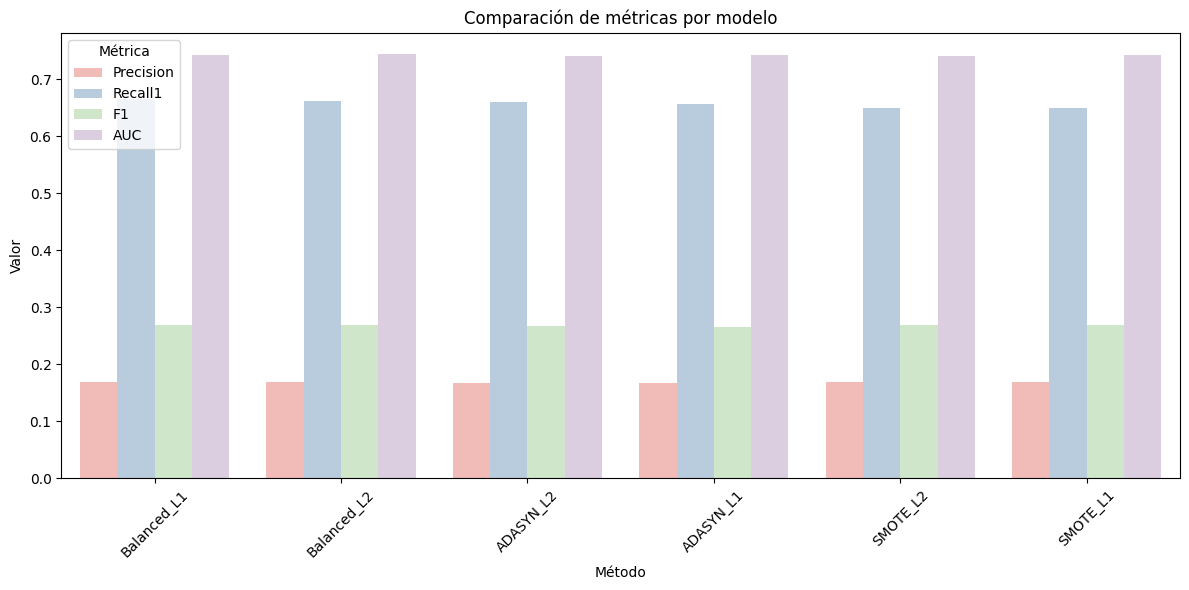

In [9]:
# Reorganizar para gráfico de barras agrupadas
df_long = df_results.melt(
    id_vars="Método",
    value_vars=["Precision", "Recall1", "F1", "AUC"],
    var_name="Métrica",
    value_name="Valor"
)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_long, x="Método", y="Valor", hue="Métrica", palette="Pastel1")
plt.title("Comparación de métricas por modelo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 8.Curvas ROC

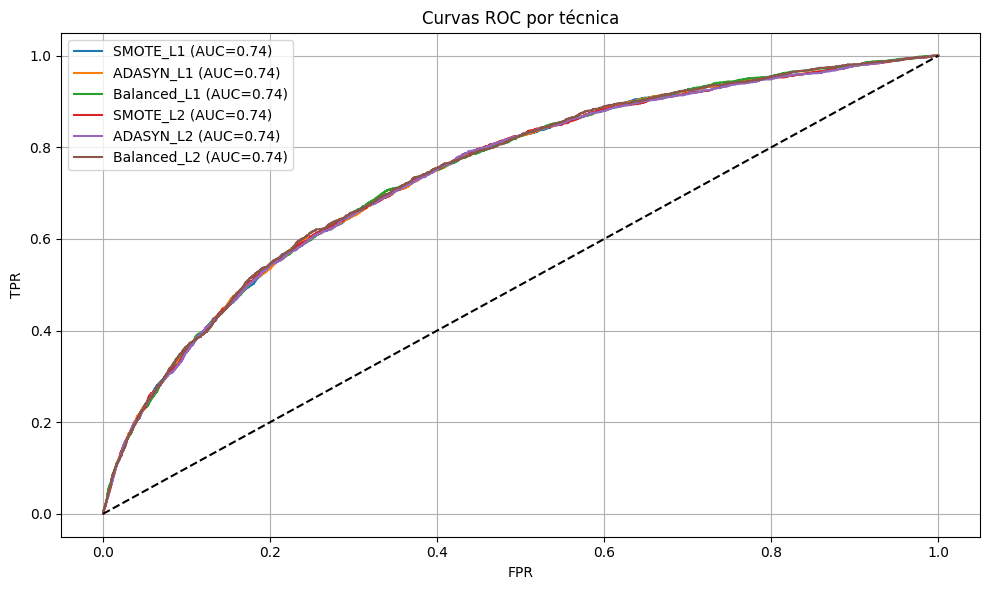

In [10]:
plt.figure(figsize=(10, 6))
for res in results:
    fpr, tpr, _ = roc_curve(y_test, res["y_prob"])
    plt.plot(fpr, tpr, label=f"{res['Método']} (AUC={res['AUC']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("Curvas ROC por técnica")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# 9.Matrices de Confusión

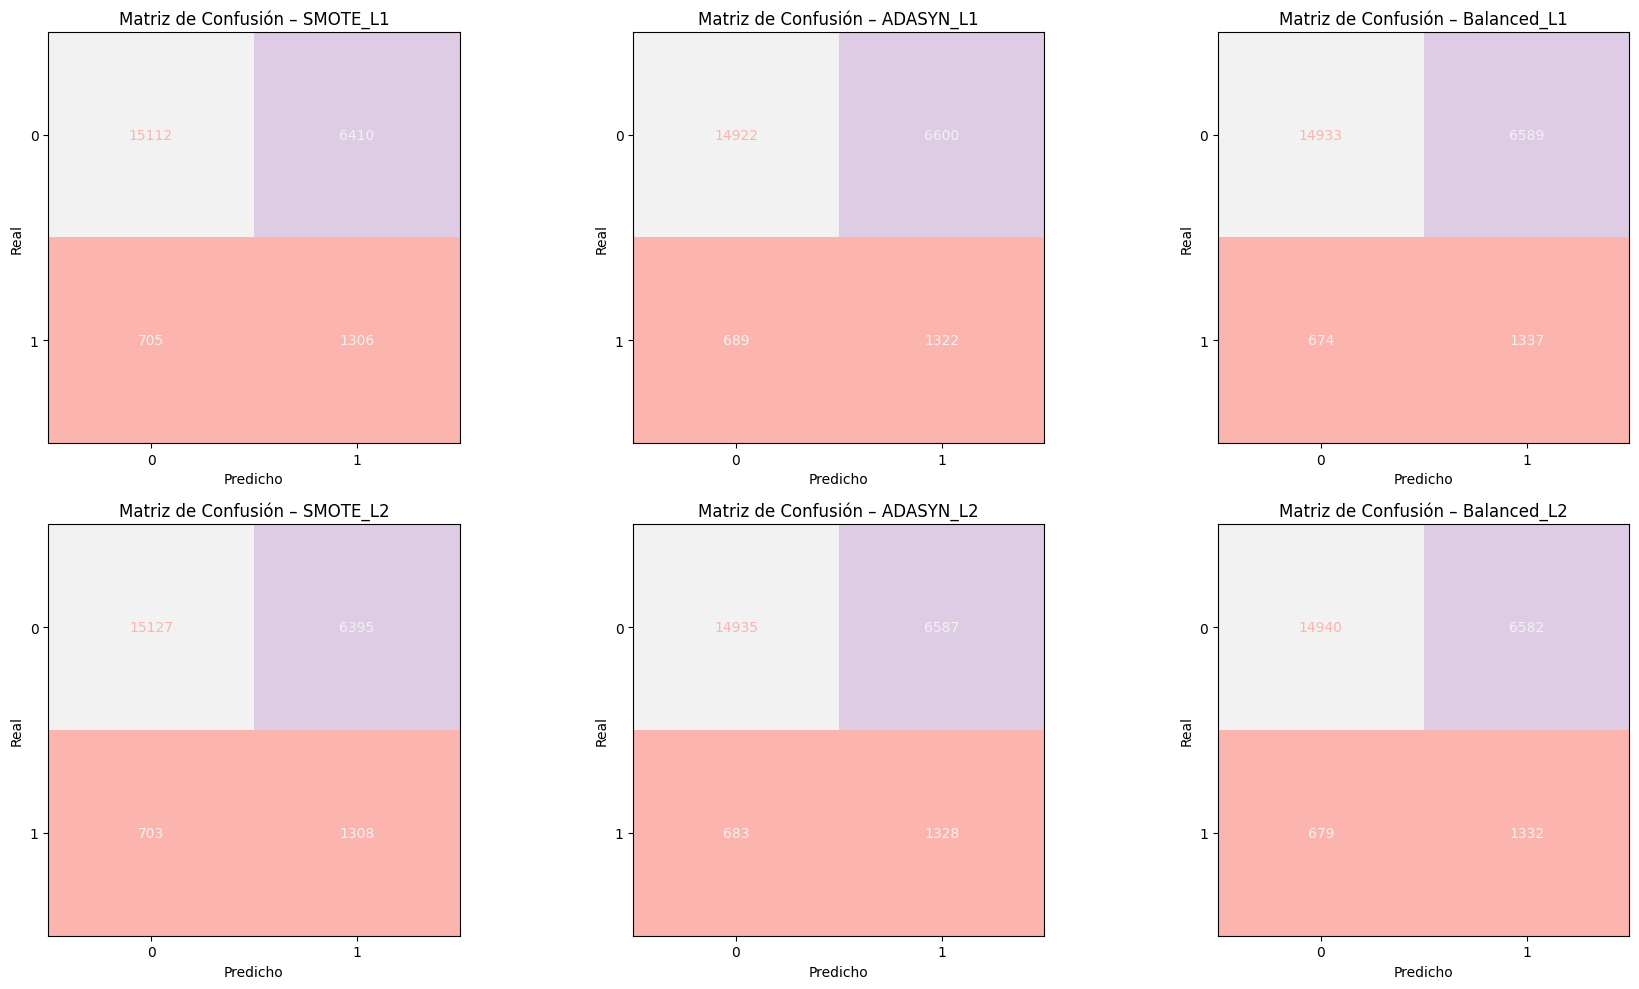

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Número de modelos
n_modelos = len(results)
n_cols = 3
n_rows = int(np.ceil(n_modelos / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, res in enumerate(results):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, res["y_pred"], ax=axes[i], cmap="Pastel1", colorbar=False
    )
    axes[i].set_title(f"Matriz de Confusión – {res['Método']}")
    axes[i].set_xlabel("Predicho")
    axes[i].set_ylabel("Real")

# Si sobran ejes, los escondemos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# 10.Gráfico de tiempo de entrenamiento

In [12]:
df_metrics = pd.DataFrame([
    {
        "Modelo": res["Método"],
        "Precision": res["Precision"],
        "Recall": res["Recall1"],
        "F1": res["F1"],
        "Accuracy": res["Accuracy"],
        "AUC": res["AUC"],
        "Tiempo (min)": res["Tiempo(m)"],  # <- clave correcta
        "C óptimo": res["Mejor_C"]
    }
    for res in results
])


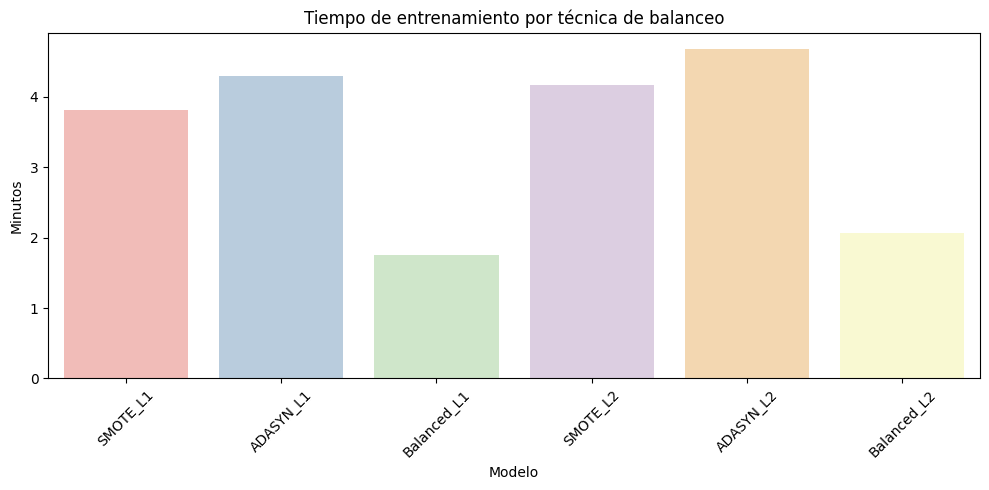

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(
    data=df_metrics,
    x="Modelo",
    y="Tiempo (min)",
    palette="Pastel1"
)
plt.xticks(rotation=45)
plt.title("Tiempo de entrenamiento por técnica de balanceo")
plt.ylabel("Minutos")
plt.tight_layout()
plt.show()


# 11.Tabla de Hiperparámetros Óptimos por Técnica y Penalización

In [14]:
# Crear tabla resumen de parámetros óptimos
tabla_hiperparametros = pd.DataFrame([
    {
        "Técnica de Balanceo": res["Método"].split("_")[0],
        "Penalización": "L1" if "L1" in res["Método"] else "L2",
        "Modelo": res["Método"],
        "C óptimo": res["Mejor_C"]
    }
    for res in results
])

# Ordenar por técnica y penalización
tabla_hiperparametros = tabla_hiperparametros.sort_values(by=["Técnica de Balanceo", "Penalización"])

# Mostrar tabla
display(tabla_hiperparametros.style.format({"C óptimo": "{:.4f}"}).background_gradient(cmap="Pastel1", subset=["C óptimo"]))


,Técnica de Balanceo,Penalización,Modelo,C óptimo
1,ADASYN,L1,ADASYN_L1,0.0100
4,ADASYN,L2,ADASYN_L2,0.1000
2,Balanced,L1,Balanced_L1,0.0100
5,Balanced,L2,Balanced_L2,1.0000
0,SMOTE,L1,SMOTE_L1,0.0100
3,SMOTE,L2,SMOTE_L2,0.0100


# 12.Curva de aprendizaje

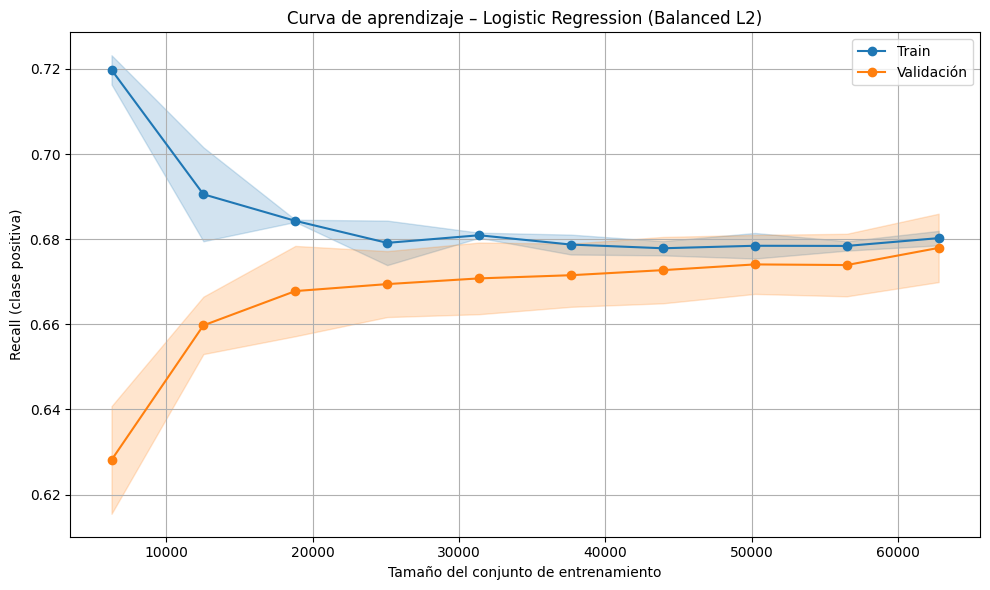

In [15]:
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import numpy as np

# Elegimos un modelo representativo, por ejemplo Balanced_L2
modelo = pipelines["Balanced_L2"]

# Obtener curvas de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    estimator=modelo,
    X=X,
    y=y,
    cv=5,
    scoring="recall",
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=8
)

# Calcular media y desvío estándar
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
val_mean   = np.mean(val_scores, axis=1)
val_std    = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Train", color="tab:blue")
plt.plot(train_sizes, val_mean, 'o-', label="Validación", color="tab:orange")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="tab:blue")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="tab:orange")

plt.title("Curva de aprendizaje – Logistic Regression (Balanced L2)")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Recall (clase positiva)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 13.Código para Curva Precision-Recall (todos los modelos comparados)

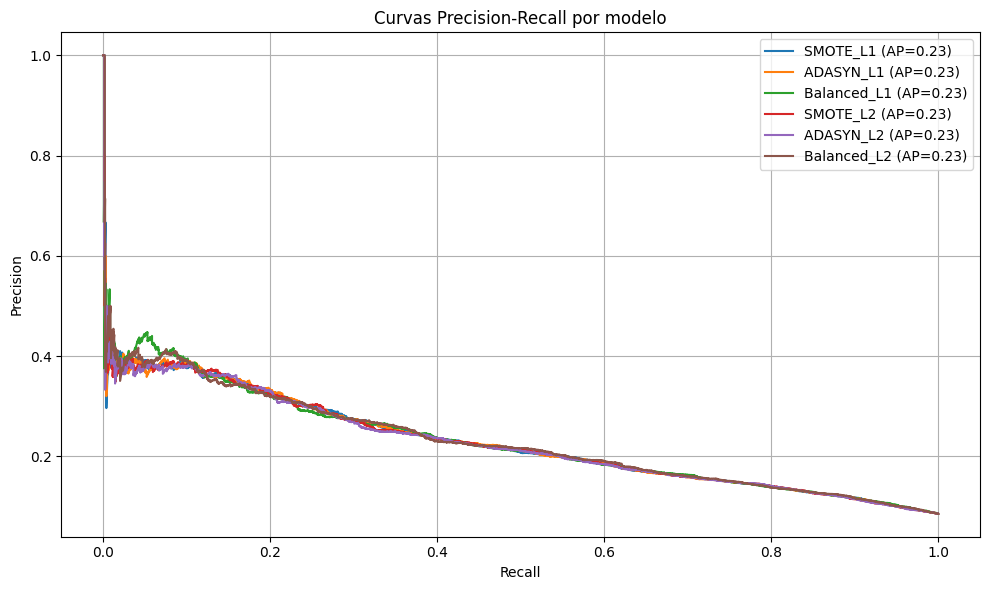

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 6))

for res in results:
    precision, recall, _ = precision_recall_curve(y_test, res["y_prob"])
    ap_score = average_precision_score(y_test, res["y_prob"])
    plt.plot(recall, precision, label=f"{res['Método']} (AP={ap_score:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas Precision-Recall por modelo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 14.Heatmap de Recall1 por Técnica vs Penalización

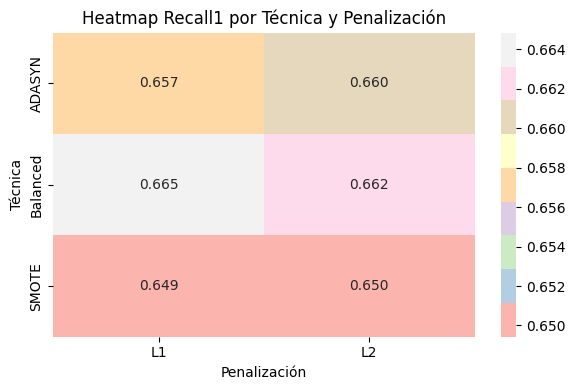

In [17]:
import warnings
warnings.filterwarnings("ignore")

df_heat = pd.DataFrame([
    {
        "Técnica": res["Método"].split("_")[0],
        "Penalización": "L1" if "L1" in res["Método"] else "L2",
        "Recall1": res["Recall1"]
    }
    for res in results
])

# Pivot con argumentos nombrados
df_pivot = df_heat.pivot(index="Técnica", columns="Penalización", values="Recall1")

plt.figure(figsize=(6, 4))
sns.heatmap(df_pivot, annot=True, fmt=".3f", cmap="Pastel1")
plt.title("Heatmap Recall1 por Técnica y Penalización")
plt.tight_layout()
plt.show()


# 15.Radar Plot por modelo para comparar métricas

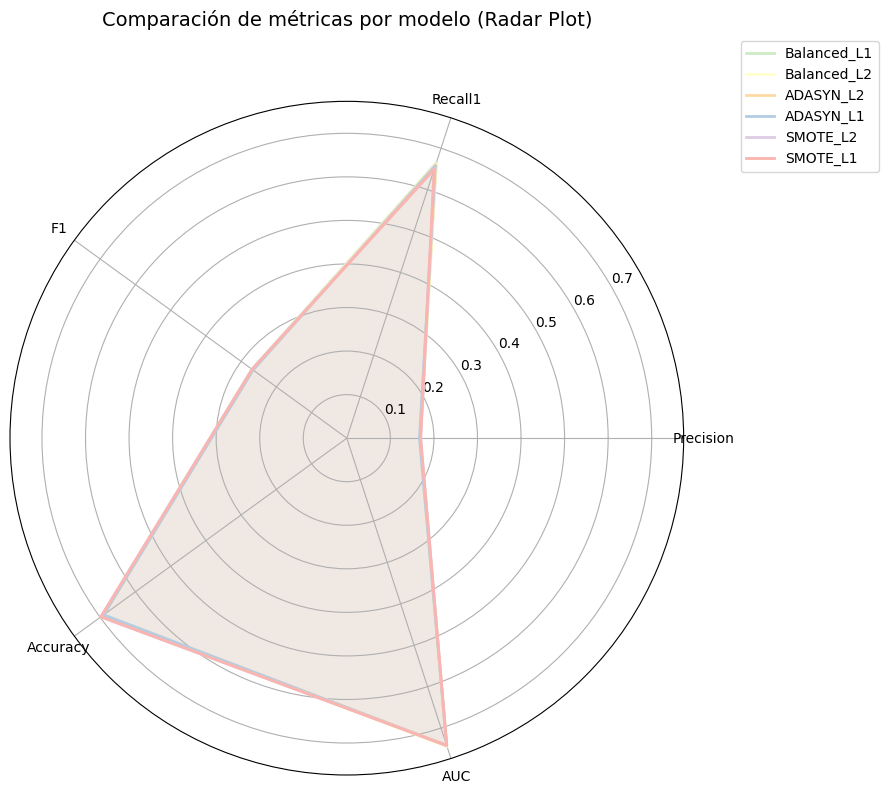

In [18]:
import warnings
warnings.filterwarnings("ignore")

from math import pi
import matplotlib.pyplot as plt

# Seleccionar y normalizar métricas (entre 0 y 1 si es necesario)
metricas = ["Precision", "Recall1", "F1", "Accuracy", "AUC"]
df_radar = df_results[["Método"] + metricas].copy()

# Reordenar para plot circular
labels = metricas
num_vars = len(labels)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # cerrar el círculo

# Estilo pastel
pastel_colors = sns.color_palette("Pastel1", n_colors=len(df_radar))

# Crear figura
plt.figure(figsize=(10, 8))
ax = plt.subplot(111, polar=True)

# Radar por modelo
for idx, row in df_radar.iterrows():
    values = row[metricas].tolist()
    values += values[:1]  # cerrar el círculo
    ax.plot(angles, values, label=row["Método"], linewidth=2, color=pastel_colors[idx])
    ax.fill(angles, values, alpha=0.1, color=pastel_colors[idx])

# Estética
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title("Comparación de métricas por modelo (Radar Plot)", y=1.1, fontsize=14)
ax.set_rlabel_position(30)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


# 16.Guardar

In [19]:
import joblib
import os

# Ruta del escritorio del usuario
desktop_path = os.path.join(os.environ["USERPROFILE"], "Desktop")

# Ruta completa para guardar modelos en el Escritorio
model_dir = os.path.join(desktop_path, "modelos_guardados")
os.makedirs(model_dir, exist_ok=True)

# Guardar cada modelo en results
for res in results:
    nombre_archivo = os.path.join(model_dir, f"{res['Método']}.joblib")
    joblib.dump(res["best_model"], nombre_archivo)

print("Modelos y pipelines guardados exitosamente en el Escritorio.")


Modelos y pipelines guardados exitosamente en el Escritorio.
